#  ITC Stock Return Prediction — Complete ML Pipeline

**Case Study: Data Science & AI**

---

##  Objective

Build a machine learning model that predicts the sector neutralized stock return for the next trading day. -> **Does it outperform the sector or not?**

**Why "outperform the sector" instead of raw price?**  
- Raw stock prices go up over time (non-stationary) — this violates ML assumptions.  
- By subtracting the **NIFTY FMCG sector return**, we isolate ITC's **alpha** — the stock-specific signal.  
- This is called **residualized return**: `Target = ITC Return − Sector Return`

---

##  Pipeline Overview

```
Step 1: Load Data (30 columns, 1297 trading days)
  ↓
Step 2: Feature Engineering (Create 27+ new technical & macro features)
  ↓
Step 3: Feature Alignment (Handle different data frequencies)
  ↓
Step 4: Leakage Audit (Remove features that "cheat")
  ↓
Step 5: Winsorization (Cap outliers at 1st/99th percentile)
  ↓
Step 6: Feature Selection (Domain-based Mutual Information)
  ↓
Step 7: Rolling Standardization (Normalize without future info)
  ↓
Step 8: Train/Val/Test Split (70/15/15 chronological)
  ↓
Step 9: Model Training (LightGBM + XGBoost)
  ↓
Step 10: Evaluation (Confusion Matrix, Accuracy, R²)
```

In [1]:
!pip install optuna
!pip install feature_engine

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


---
## Step 1: Setup & Data Loading

In [2]:
# ============================================================
# IMPORTS
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# ML Libraries
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor
from sklearn.metrics import (r2_score, mean_absolute_error, accuracy_score,
                             confusion_matrix, classification_report)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import mutual_info_regression
from feature_engine.outliers import Winsorizer

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
RANDOM_STATE = 42

print('✅ Libraries loaded')

✅ Libraries loaded


In [3]:
# ============================================================
# LOAD THE MERGED DATASET
# ============================================================
df = pd.read_csv('../data/processed/HINDUNILVR.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)
df = df.loc[:, ~df.columns.duplicated()]  # Remove duplicate columns if any

print(f'📊 Shape: {df.shape[0]} rows × {df.shape[1]} columns')
print(f'📅 Period: {df["Date"].min().date()} → {df["Date"].max().date()}')
print(f'\n📋 Columns:')
for i, col in enumerate(df.columns, 1):
    print(f'  {i:2d}. {col}')

df.tail()

📊 Shape: 1486 rows × 32 columns
📅 Period: 2020-01-01 → 2025-12-30

📋 Columns:
   1. Date
   2. open
   3. high
   4. low
   5. close
   6. volume
   7. close_sector
   8. return
   9. return_pct
  10. sector_return
  11. sector_return_pct
  12. target_raw_return
  13. target_residualized
  14. volume_z
  15. high_volume
  16. Revenue
  17. Net_Income
  18. Profit_Margin
  19. Revenue_Growth
  20. Profit_Growth
  21. US Dollar
  22. Pound Sterling
  23. Euro
  24. Japanese Yen
  25. Central Government Dated Securities
  26. State Government Dated Securities
  27. 91-Day
  28. 182-Day
  29. 364-Day
  30. RBI
  31. Brent_Crude
  32. Inflation


,Date,open,high,low,close,volume,close_sector,return,return_pct,sector_return,sector_return_pct,target_raw_return,target_residualized,volume_z,high_volume,Revenue,Net_Income,Profit_Margin,Revenue_Growth,Profit_Growth,US Dollar,Pound Sterling,Euro,Japanese Yen,Central Government Dated Securities,State Government Dated Securities,91-Day,182-Day,364-Day,RBI,Brent_Crude,Inflation
1481,2025-12-23,2289.300049,2310.000000,2280.699951,2302.600098,1128801,55348.648438,13.100098,0.005722,286.000000,0.005194,-0.008860,0.000528,-0.726452,0,162410.0,26850.0,0.165322,-0.016531,-0.025762,89.603897,120.657532,105.330002,0.570841,576619.0,71582.0,45924.0,19177.0,19872.0,52487.0,62.380001,157.5517
1482,2025-12-24,2302.600098,2305.000000,2278.100098,2282.199951,519380,55113.750000,-20.400146,-0.008860,-234.898438,-0.004244,0.001402,-0.004616,-1.279734,0,162410.0,26850.0,0.165322,-0.016531,-0.025762,89.507896,120.982994,105.407997,0.572258,576619.0,71582.0,45924.0,19177.0,19872.0,52487.0,62.240002,157.5517
1483,2025-12-26,2282.300049,2290.000000,2275.000000,2285.399902,533626,55132.050781,3.199951,0.001402,18.300781,0.000332,0.003457,0.001070,-1.152934,0,162410.0,26850.0,0.165322,-0.016531,-0.025762,90.105904,121.594879,105.679001,0.575622,576619.0,71582.0,45924.0,19177.0,19872.0,52487.0,60.639999,157.5517
1484,2025-12-29,2288.899902,2298.699951,2280.000000,2293.300049,1086695,55192.449219,7.900146,0.003457,60.398438,0.001096,-0.001352,0.002361,-0.622346,0,162410.0,26850.0,0.165322,-0.016531,-0.025762,89.829300,121.263229,105.711998,0.576229,576619.0,71582.0,45924.0,19177.0,19872.0,52487.0,61.939999,157.5517
1485,2025-12-30,2293.300049,2298.000000,2283.000000,2290.199951,1556717,55192.449219,-3.100098,-0.001352,0.000000,0.000000,-0.001352,-0.001352,-0.144942,0,162410.0,26850.0,0.165322,-0.016531,-0.025762,89.900002,121.416885,105.754997,0.575697,576619.0,71582.0,45924.0,19177.0,19872.0,52487.0,61.919998,157.5517


---
## Step 2: Understanding the Raw Data

Our dataset combines **4 different data sources** that were collected and merged beforehand:

| Source | Columns | Frequency | How It Was Collected |
|:---|:---|:---|:---|
| **Yahoo Finance** | `open, high, low, close, volume` | Daily | `yfinance` Python library |
| **Yahoo Finance** | `close_sector` (NIFTY FMCG Index) | Daily | `yfinance` |
| **RBI / CCIL** | `91-Day, 182-Day, 364-Day, RBI` (Treasury Yields) | Daily | Government bond data |
| **Investing.com** | `US Dollar, Pound Sterling, Euro, Japanese Yen` | Daily | Currency exchange rates |
| **MoneyControl** | `Revenue, Net_Income, Profit_Margin` etc. | **Quarterly** | Public earnings reports (24 quarters) |

### ⚠️ Feature Alignment Challenge
These data sources have **different frequencies**:
- Stock prices → **Daily** (1,297 data points)
- Fundamentals → **Quarterly** (24 data points over 6 years)
- Macro data → **Daily** but sometimes has gaps on holidays

**How we aligned them:**
- **Fundamentals** were merged using `merge_asof(direction='backward')` — each trading day gets the **most recent** quarterly report. This simulates real-world availability (you only know Q2 results after they're published).
- **Macro data** was forward-filled (`ffill`) for holiday gaps.
- The **target variable** is shifted by 1 day: `target = next_day_return - next_day_sector_return` (we predict tomorrow, not today).

In [4]:
display(df[['Date', 'return_pct', 'sector_return_pct', 'target_raw_return', 'target_residualized']].tail())

,Date,return_pct,sector_return_pct,target_raw_return,target_residualized
1481,2025-12-23,0.005722,0.005194,-0.008860,0.000528
1482,2025-12-24,-0.008860,-0.004244,0.001402,-0.004616
1483,2025-12-26,0.001402,0.000332,0.003457,0.001070
1484,2025-12-29,0.003457,0.001096,-0.001352,0.002361
1485,2025-12-30,-0.001352,0.000000,-0.001352,-0.001352


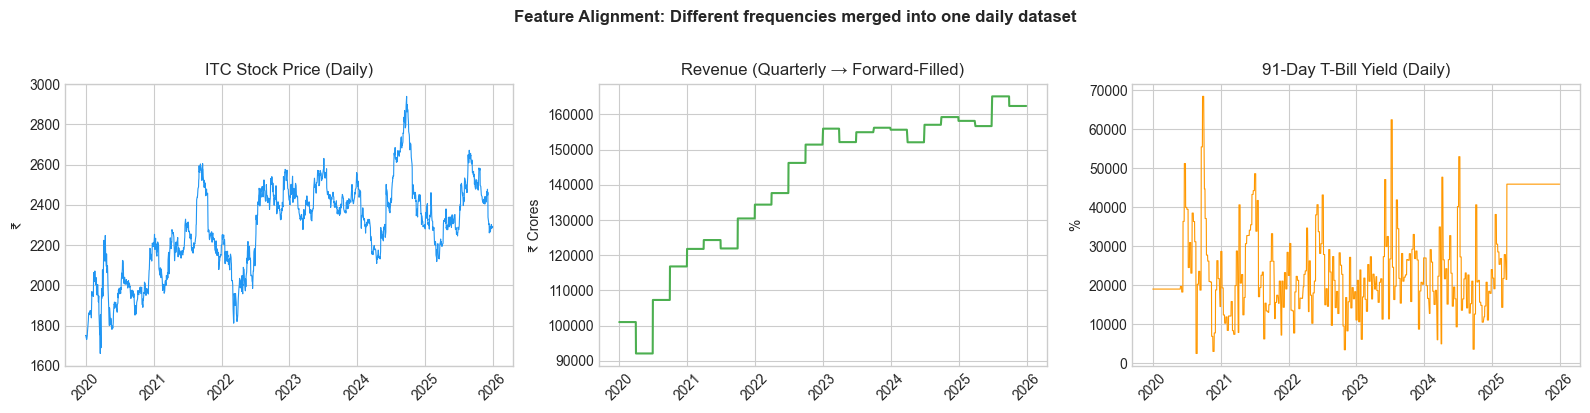

Notice how Revenue changes in STEPS (quarterly), while Price and Yields change daily.
Revenue has 24 unique values across 1486 trading days.


In [5]:
# ============================================================
# VISUALIZE: How fundamentals change over time (step function)
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

axes[0].plot(df['Date'], df['close'], color='#2196F3', linewidth=0.8)
axes[0].set_title('ITC Stock Price (Daily)')
axes[0].set_ylabel('₹')

axes[1].plot(df['Date'], df['Revenue'], color='#4CAF50', linewidth=1.5)
axes[1].set_title('Revenue (Quarterly → Forward-Filled)')
axes[1].set_ylabel('₹ Crores')

axes[2].plot(df['Date'], df['91-Day'], color='#FF9800', linewidth=0.8)
axes[2].set_title('91-Day T-Bill Yield (Daily)')
axes[2].set_ylabel('%')

for ax in axes:
    ax.tick_params(axis='x', rotation=45)
plt.suptitle('Feature Alignment: Different frequencies merged into one daily dataset',
             fontsize=12, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print('Notice how Revenue changes in STEPS (quarterly), while Price and Yields change daily.')
print(f'Revenue has {df["Revenue"].nunique()} unique values across {len(df)} trading days.')

---
## Step 3: Target Variable

Our target is the **next-day residualized return**:

$$\text{target} = \text{ITC Return}_{t+1} - \text{Sector Return}_{t+1}$$

- **Positive target** → ITC outperformed its sector (BUY signal)
- **Negative target** → ITC underperformed its sector (SELL signal)

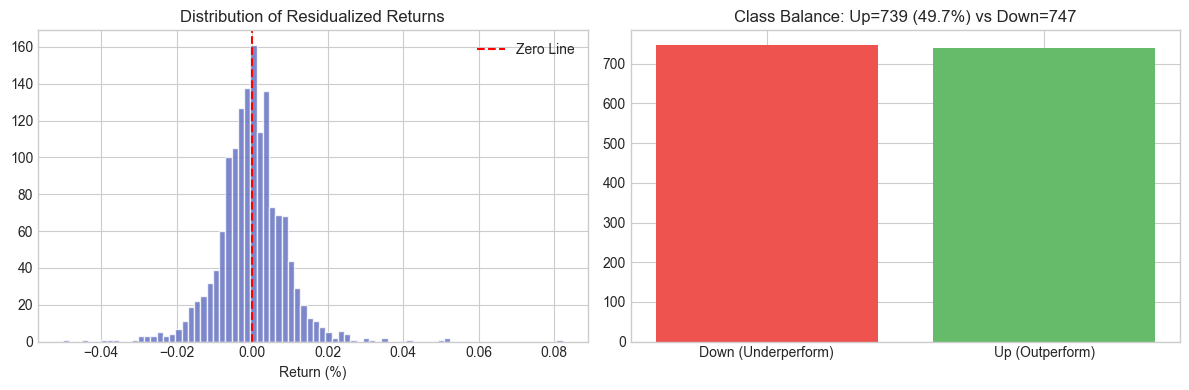

Mean: -0.0002%, Std: 0.0092%


In [6]:
# ============================================================
# VISUALIZE THE TARGET DISTRIBUTION
# ============================================================
target = df['target_residualized'].dropna()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Distribution
axes[0].hist(target, bins=80, color='#5C6BC0', edgecolor='white', alpha=0.8)
axes[0].axvline(0, color='red', linestyle='--', linewidth=1.5, label='Zero Line')
axes[0].set_title('Distribution of Residualized Returns')
axes[0].set_xlabel('Return (%)')
axes[0].legend()

# Class Balance
up = (target >= 0).sum()
down = (target < 0).sum()
axes[1].bar(['Down (Underperform)', 'Up (Outperform)'], [down, up],
            color=['#EF5350', '#66BB6A'])
axes[1].set_title(f'Class Balance: Up={up} ({up/(up+down)*100:.1f}%) vs Down={down}')

plt.tight_layout()
plt.show()
print(f'Mean: {target.mean():.4f}%, Std: {target.std():.4f}%')

---
## Step 4: Feature Engineering — Technical Indicators 📐

We create **new features** from the raw price/volume data. These capture patterns that traders use:

### 4a. Moving Averages (SMA & EMA)
- **SMA (Simple Moving Average):** Average of last N days. Smooths noise.
- **EMA (Exponential Moving Average):** Gives more weight to recent days.
- *Why?* If price is above its SMA, the stock is in an **uptrend**.

### 4b. RSI (Relative Strength Index)
- Measures whether a stock is **overbought** (RSI > 70) or **oversold** (RSI < 30).
- Formula: `RSI = 100 - (100 / (1 + RS))` where `RS = Avg Gain / Avg Loss` over 14 days.

### 4c. MACD (Moving Average Convergence Divergence)
- Difference between 12-day EMA and 26-day EMA.
- When MACD crosses above its signal line → **bullish**.

### 4d. Bollinger Bands
- Upper Band = SMA(20) + 2×StdDev, Lower Band = SMA(20) − 2×StdDev
- **Bandwidth** = How volatile the stock is. **%B** = Where price sits within the bands.

### 4e. Buying & Selling Pressure
- **Buying Pressure** = `(Close − Low) / (High − Low)` → Did buyers push price up from the low?
- **Selling Pressure** = `(High − Close) / (High − Low)` → Did sellers push price down from the high?

### 4f. Lagged Features
- Yesterday's return, 2-day-ago return, etc. Captures **momentum** and **mean reversion** effects.
- Lagged volume captures **whether attention is increasing or decreasing**.

In [7]:
# ============================================================
# FEATURE ENGINEERING
# ============================================================
def create_technical_features(df):
    """Create all technical indicator features from price & volume data."""
    df = df.copy()
    eps = 1e-9  # Small number to avoid division by zero

    # ----- 1. BUYING & SELLING PRESSURE -----
    df['Buying_Pressure']  = (df['close'] - df['low'])  / (df['high'] - df['low'] + eps)
    df['Selling_Pressure'] = (df['high'] - df['close']) / (df['high'] - df['low'] + eps)

    # ----- 2. MOVING AVERAGES -----
    for window in [5, 10, 20, 50]:
        df[f'SMA_{window}'] = df['close'].rolling(window=window).mean()
    for span in [12, 26]:
        df[f'EMA_{span}'] = df['close'].ewm(span=span, adjust=False).mean()

    # ----- 3. MACD -----
    df['MACD']        = df['EMA_12'] - df['EMA_26']
    df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # ----- 4. RSI (14-day) -----
    delta = df['close'].diff()
    gain  = delta.where(delta > 0, 0).rolling(14).mean()
    loss  = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    df['RSI_14'] = 100 - (100 / (1 + rs))

    # ----- 5. BOLLINGER BANDS -----
    df['BB_middle'] = df['close'].rolling(20).mean()
    df['BB_std']    = df['close'].rolling(20).std()
    df['BB_upper']  = df['BB_middle'] + 2 * df['BB_std']
    df['BB_lower']  = df['BB_middle'] - 2 * df['BB_std']
    df['BB_bandwidth'] = (df['BB_upper'] - df['BB_lower']) / df['BB_middle']
    df['BB_pct']       = (df['close'] - df['BB_lower']) / (df['BB_upper'] - df['BB_lower'])

    # ----- 6. LAGGED FEATURES -----
    for lag in [1, 2, 3, 5]:
        df[f'return_lag{lag}'] = df['return_pct'].shift(lag)   # Past returns
        df[f'volume_lag{lag}'] = df['volume'].shift(lag)       # Past volume

    # ----- 7. INFLATION & REAL INTEREST RATE -----
    INFLATION = {
        '2020-01': 7.59, '2020-02': 6.58, '2020-03': 5.91, '2020-04': 7.22, '2020-05': 6.27, '2020-06': 6.09,
        '2020-07': 6.93, '2020-08': 6.69, '2020-09': 7.27, '2020-10': 7.61, '2020-11': 6.93, '2020-12': 4.59,
        '2021-01': 4.06, '2021-02': 5.03, '2021-03': 5.52, '2021-04': 4.29, '2021-05': 6.30, '2021-06': 6.26,
        '2021-07': 5.59, '2021-08': 5.30, '2021-09': 4.35, '2021-10': 4.48, '2021-11': 4.91, '2021-12': 5.59,
        '2022-01': 6.01, '2022-02': 6.07, '2022-03': 6.95, '2022-04': 7.79, '2022-05': 7.04, '2022-06': 7.01,
        '2022-07': 6.71, '2022-08': 7.00, '2022-09': 7.41, '2022-10': 6.77, '2022-11': 5.88, '2022-12': 5.72,
        '2023-01': 6.52, '2023-02': 6.44, '2023-03': 5.66, '2023-04': 4.70, '2023-05': 4.25, '2023-06': 4.81,
        '2023-07': 7.44, '2023-08': 6.83, '2023-09': 5.02, '2023-10': 4.87, '2023-11': 5.55, '2023-12': 5.69,
        '2024-01': 5.10, '2024-02': 5.10, '2024-03': 4.90, '2024-04': 4.80, '2024-05': 4.80, '2024-06': 5.10,
    }
    ym = df['Date'].dt.strftime('%Y-%m')
    df['Inflation_CPI'] = ym.map(INFLATION).ffill()
    if '91-Day' in df.columns:
        df['Real_Interest_Rate'] = df['91-Day'] - df['Inflation_CPI']

    return df

df = create_technical_features(df)
print(f'✅ Technical features created. Total columns: {len(df.columns)}')
print(f'   New features include: SMA_5/10/20/50, EMA_12/26, MACD, RSI_14,')
print(f'   BB_bandwidth, BB_pct, Buying/Selling Pressure, 4 Return Lags, 4 Volume Lags')

✅ Technical features created. Total columns: 59
   New features include: SMA_5/10/20/50, EMA_12/26, MACD, RSI_14,
   BB_bandwidth, BB_pct, Buying/Selling Pressure, 4 Return Lags, 4 Volume Lags


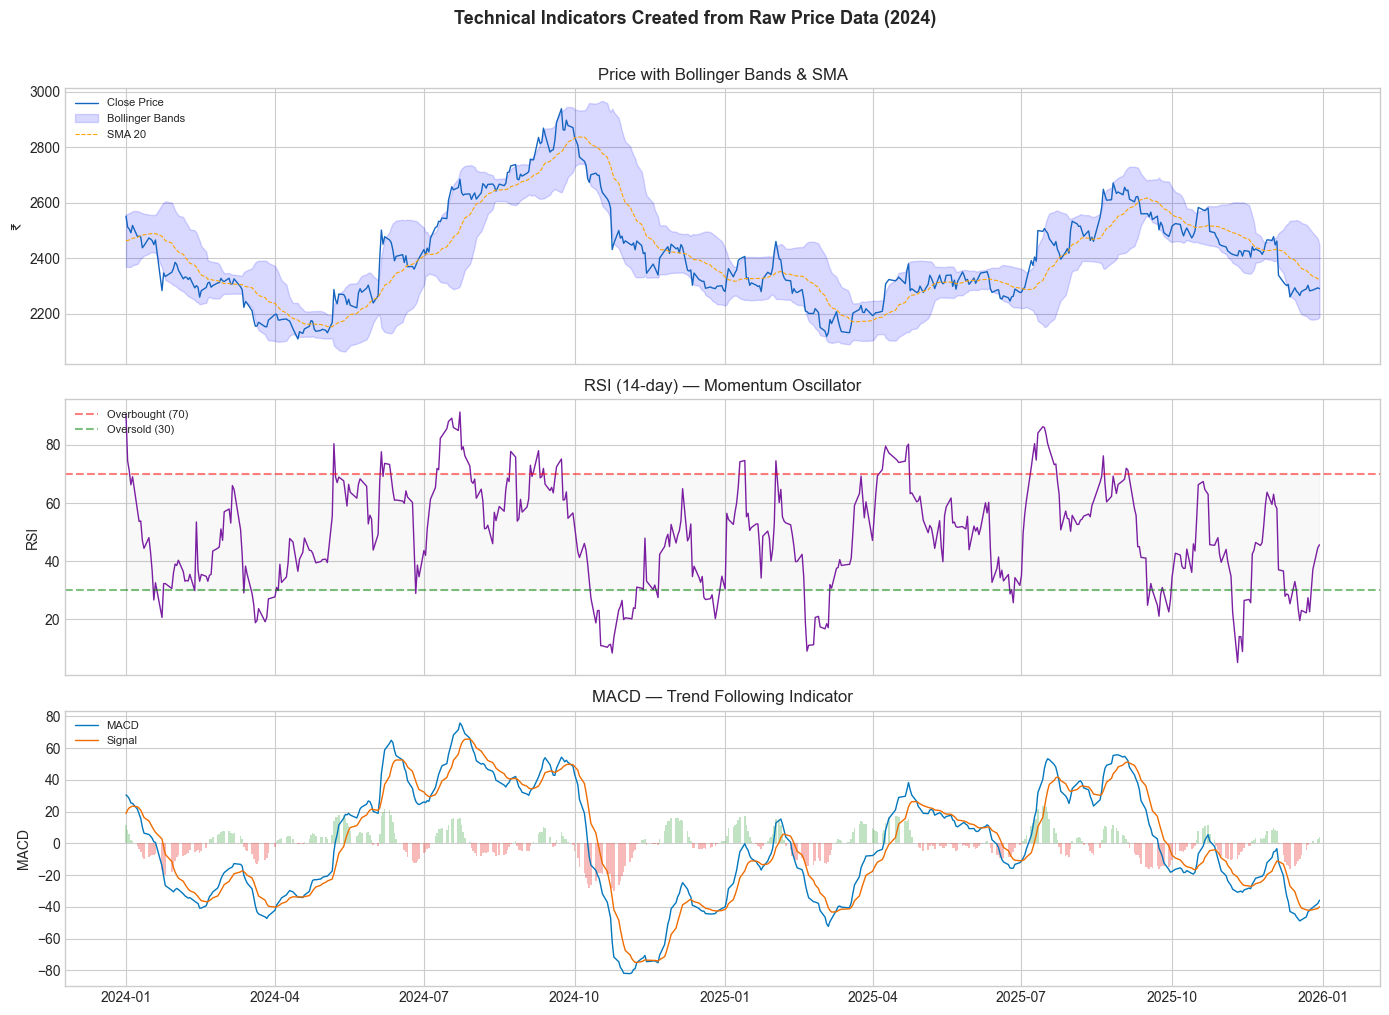

In [8]:
# ============================================================
# VISUALIZE: Some of the technical indicators we created
# ============================================================
recent = df[df['Date'] >= '2024-01-01'].copy()

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# 1. Price with Bollinger Bands
axes[0].plot(recent['Date'], recent['close'], label='Close Price', color='#1565C0', linewidth=1)
axes[0].fill_between(recent['Date'], recent['BB_lower'], recent['BB_upper'],
                     alpha=0.15, color='blue', label='Bollinger Bands')
axes[0].plot(recent['Date'], recent['SMA_20'], '--', color='orange', linewidth=0.8, label='SMA 20')
axes[0].set_title('Price with Bollinger Bands & SMA')
axes[0].legend(loc='upper left', fontsize=8)
axes[0].set_ylabel('₹')

# 2. RSI
axes[1].plot(recent['Date'], recent['RSI_14'], color='#7B1FA2', linewidth=1)
axes[1].axhline(70, color='red', linestyle='--', alpha=0.5, label='Overbought (70)')
axes[1].axhline(30, color='green', linestyle='--', alpha=0.5, label='Oversold (30)')
axes[1].fill_between(recent['Date'], 30, 70, alpha=0.05, color='gray')
axes[1].set_title('RSI (14-day) — Momentum Oscillator')
axes[1].legend(loc='upper left', fontsize=8)
axes[1].set_ylabel('RSI')

# 3. MACD
axes[2].plot(recent['Date'], recent['MACD'], label='MACD', color='#0277BD', linewidth=1)
axes[2].plot(recent['Date'], recent['MACD_signal'], label='Signal', color='#EF6C00', linewidth=1)
macd_hist = recent['MACD'] - recent['MACD_signal']
colors = ['#66BB6A' if v >= 0 else '#EF5350' for v in macd_hist]
axes[2].bar(recent['Date'], macd_hist, color=colors, alpha=0.4, width=1)
axes[2].set_title('MACD — Trend Following Indicator')
axes[2].legend(loc='upper left', fontsize=8)
axes[2].set_ylabel('MACD')

plt.suptitle('Technical Indicators Created from Raw Price Data (2024)',
             fontsize=13, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

---
## Step 5: Data Leakage Audit ⚠️

**Data leakage** is when your model accidentally uses information it wouldn't have in the real world. This is the #1 reason for fake-good results in ML.

### Features We MUST Exclude:

| Feature | Why It's Excluded |
|:---|:---|
| `close, high, low, open` | Raw prices are **non-stationary** — they trend over time, causing spurious correlations |
| `close_sector` | Used to calculate `sector_return` which is part of our target |
| `return, return_pct` | Today's return — we're predicting **tomorrow's** return |
| `target_raw_return` | Alternative target — can't use as input! |

### ✅ What We Keep:
- **Volume** (independent market activity)
- **Technical indicators** (computed from past data only, via `.shift()` and `.rolling()`)
- **Macro indicators** (interest rates, currencies — external to ITC)
- **Fundamentals** (quarterly — known before the trading day)

In [9]:
# ============================================================
# DEFINE WHAT TO EXCLUDE
# ============================================================
META_COLS   = ['Date']
TARGET_COLS = ['target_residualized', 'target_raw_return', 'return', 'return_pct',
               'sector_return', 'sector_return_pct']
LEAKY_COLS  = ['close', 'high', 'low', 'open', 'close_sector']

EXCLUDE = META_COLS + TARGET_COLS + LEAKY_COLS

# Fundamentals are "low variation" (change quarterly) — we keep them but don't winsorize
FUNDAMENTAL_COLS = ['Revenue', 'Net_Income', 'Profit_Margin', 'Revenue_Growth', 'Profit_Growth']

# Get all numeric feature candidates
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
candidate_features = [c for c in numeric_cols if c not in EXCLUDE and c not in FUNDAMENTAL_COLS]

print(f'Total numeric columns: {len(numeric_cols)}')
print(f'Excluded (meta + target + leaky): {len(EXCLUDE)}')
print(f'Fundamental (kept but not winsorized): {len(FUNDAMENTAL_COLS)}')
print(f'Feature candidates for modeling: {len(candidate_features)}')

Total numeric columns: 58
Excluded (meta + target + leaky): 12
Fundamental (kept but not winsorized): 5
Feature candidates for modeling: 42


---
## Step 6: Missing Data Handling & Winsorization

### Missing Data Strategy:
1. **Technical indicators** have NaN for the first ~50 rows (warm-up period for rolling calculations). → We drop these rows.
2. **Fundamentals** are already forward-filled from quarterly reports.

### Winsorization:
Extreme values (like COVID crash volumes) can mislead the model. We **cap** all continuous features at the **1st and 99th percentiles**.

Example: If normal volume is 5M–20M shares, but one day it was 100M (panic selling), we cap it to ~20M.

In [10]:
# ============================================================
# CLEAN & WINSORIZE
# ============================================================
# Drop columns with excessive NaNs (>15% missing)
nan_pct = df.isnull().sum() / len(df) * 100
cols_to_drop = nan_pct[nan_pct > 15].index.tolist()
if cols_to_drop:
    print(f'Dropping columns with >15% NaN: {cols_to_drop}')
    df = df.drop(columns=cols_to_drop)
    candidate_features = [c for c in candidate_features if c in df.columns]

# Drop remaining NaN rows (from technical indicator warm-up)
rows_before = len(df)
df_clean = df.dropna()
print(f'Dropped {rows_before - len(df_clean)} rows (technical warm-up period)')
print(f'Remaining: {len(df_clean)} rows')

# Winsorize continuous features
existing_candidates = [c for c in candidate_features if c in df_clean.columns]
winsorizer = Winsorizer(capping_method='quantiles', tail='both',
                        fold=0.01, variables=existing_candidates)
df_wins = winsorizer.fit_transform(df_clean)
print(f'\n✅ Winsorization applied to {len(existing_candidates)} features (1st–99th pctile)')

Dropped 49 rows (technical warm-up period)
Remaining: 1437 rows

✅ Winsorization applied to 42 features (1st–99th pctile)


---
## Step 7: Feature Selection — Domain-Based Mutual Information 🧠

### The Problem: Multicollinearity
Many features measure the **same thing**:
- `91-Day Yield` and `182-Day Yield` are 99% correlated
- `SMA_5` and `SMA_10` both measure short-term trend
- `USD/INR` and `EUR/INR` often move together

Feeding all of them confuses the model and increases noise.

### Our Solution: Domain Grouping
1. **Group** features by domain (Yields, Currencies, Momentum, etc.)
2. **Calculate Mutual Information (MI)** of each feature with the target
3. **Keep only the BEST** feature from each group

**What is Mutual Information?**
- Like correlation, but captures **non-linear** relationships too
- MI = 0 means the feature tells you nothing about the target
- Higher MI = more useful feature

In [11]:
# ============================================================
# FEATURE SELECTION: DOMAIN-BASED MUTUAL INFORMATION
# ============================================================
# Prepare feature matrix
all_feature_cols = existing_candidates + [c for c in FUNDAMENTAL_COLS if c in df_wins.columns]
X_all = df_wins[all_feature_cols].copy()
y = df_wins['target_residualized'].copy()

# Calculate Mutual Information for every feature
mi_scores = mutual_info_regression(X_all.fillna(0), y, random_state=RANDOM_STATE)
mi_series = pd.Series(mi_scores, index=X_all.columns).sort_values(ascending=False)

# Define domain groups
DOMAIN_GROUPS = {
    'Treasury Yields':  ['91-Day', '182-Day', '364-Day', 'RBI'],
    'Currencies':       ['US Dollar', 'Pound Sterling', 'Euro', 'Japanese Yen'],
    'Momentum':         ['RSI', 'MACD', 'return_lag', 'Buying_Pressure'],
    'Bollinger':        ['BB_bandwidth', 'BB_pct'],
    'Fundamentals':     ['Revenue', 'Net_Income', 'Profit_Margin'],
    'Growth':           ['Revenue_Growth', 'Profit_Growth'],
}

# For each group: keep best, drop rest
features_to_drop = set()
print('Domain-Based Feature Selection Results:')
print('=' * 70)
for domain, keywords in DOMAIN_GROUPS.items():
    if domain in ['Fundamentals', 'Growth']:
        group = [f for f in keywords if f in X_all.columns]
    else:
        group = [f for f in X_all.columns if any(k in f for k in keywords)]

    if len(group) <= 1:
        continue

    winner = mi_series[group].idxmax()
    losers = set(group) - {winner}
    features_to_drop.update(losers)
    print(f'  {domain:<18} → Winner: {winner:<22} (MI={mi_series[winner]:.4f}) | Dropped: {len(losers)} others')

SELECTED = [c for c in X_all.columns if c not in features_to_drop]
print(f'\n✅ Selected {len(SELECTED)} features (from {len(X_all.columns)} candidates)')
print(f'   Features: {SELECTED}')

Domain-Based Feature Selection Results:
  Treasury Yields    → Winner: 182-Day                (MI=0.0482) | Dropped: 3 others
  Currencies         → Winner: Pound Sterling         (MI=0.0276) | Dropped: 3 others
  Momentum           → Winner: Buying_Pressure        (MI=0.2315) | Dropped: 7 others
  Bollinger          → Winner: BB_bandwidth           (MI=0.0573) | Dropped: 1 others
  Fundamentals       → Winner: Net_Income             (MI=0.0416) | Dropped: 2 others
  Growth             → Winner: Revenue_Growth         (MI=0.0256) | Dropped: 1 others

✅ Selected 30 features (from 47 candidates)
   Features: ['volume', 'volume_z', 'high_volume', 'Pound Sterling', 'Central Government Dated Securities', 'State Government Dated Securities', '182-Day', 'Brent_Crude', 'Inflation', 'Buying_Pressure', 'Selling_Pressure', 'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_12', 'EMA_26', 'BB_middle', 'BB_std', 'BB_upper', 'BB_lower', 'BB_bandwidth', 'volume_lag1', 'volume_lag2', 'volume_lag3', 'volume_l

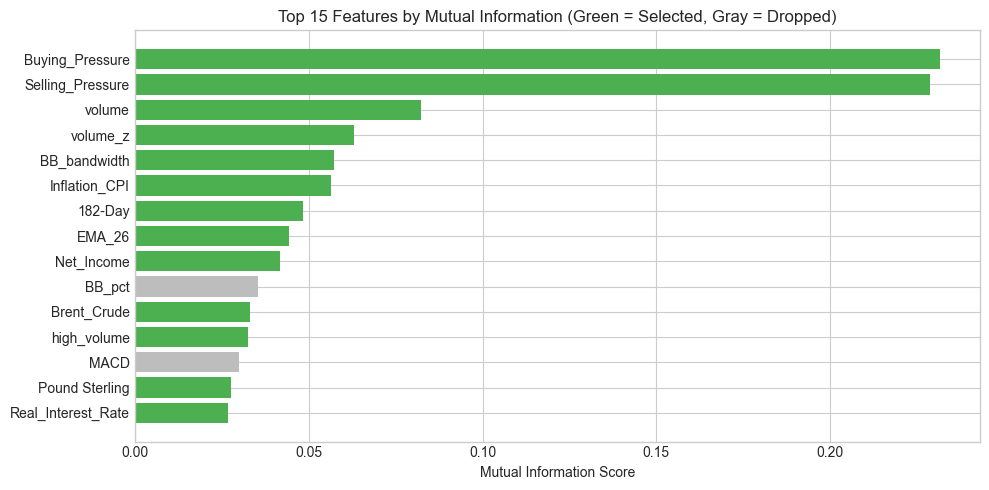

In [12]:
# ============================================================
# VISUALIZE: Top features by Mutual Information
# ============================================================
top_mi = mi_series.head(15)

plt.figure(figsize=(10, 5))
colors = ['#4CAF50' if f in SELECTED else '#BDBDBD' for f in top_mi.index]
plt.barh(range(len(top_mi)), top_mi.values, color=colors)
plt.yticks(range(len(top_mi)), top_mi.index)
plt.xlabel('Mutual Information Score')
plt.title('Top 15 Features by Mutual Information (Green = Selected, Gray = Dropped)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

---
## Step 8: Interaction Features & Rolling Standardization

### Interaction Features
Sometimes the **combination** of two features is more predictive than either alone.  
Example: `High Volume × RSI Oversold` might be a stronger buy signal than either feature individually.

We create **pairwise interactions** for the top 6 features.

### Rolling Standardization
Standard scaling (mean=0, std=1) normally uses the **entire dataset** — this leaks future information!

Instead, we use a **30-day rolling window**:
$$z_t = \frac{x_t - \text{mean}(x_{t-30} \ldots x_{t-1})}{\text{std}(x_{t-30} \ldots x_{t-1})}$$

This ensures we only use **past data** to normalize — just like in real trading.

In [13]:
# ============================================================
# INTERACTION FEATURES
# ============================================================
# Pick top 6 features by MI for interactions
mi_selected = mutual_info_regression(df_wins[SELECTED].fillna(0), y, random_state=RANDOM_STATE)
top_6 = pd.Series(mi_selected, index=SELECTED).nlargest(6).index.tolist()
print(f'Creating interactions from top 6: {top_6}')

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
inter_matrix = poly.fit_transform(df_wins[top_6])
inter_names = poly.get_feature_names_out(top_6)
inter_df = pd.DataFrame(inter_matrix, columns=inter_names, index=df_wins.index)

df_final = pd.concat([df_wins, inter_df], axis=1)
ALL_FEATS = list(dict.fromkeys(SELECTED + list(inter_names)))  # Deduplicate

print(f'✅ Added {len(inter_names) - len(top_6)} interaction features')
print(f'   Total features for modeling: {len(ALL_FEATS)}')

Creating interactions from top 6: ['Buying_Pressure', 'Selling_Pressure', 'volume', 'volume_z', 'BB_bandwidth', 'Inflation_CPI']
✅ Added 15 interaction features
   Total features for modeling: 45


In [14]:
# ============================================================
# ROLLING STANDARDIZATION (30-day lookback)
# ============================================================
ROLLING_WINDOW = 30
df_scaled = df_final.copy()

for col in ALL_FEATS:
    if col not in df_final.columns:
        continue
    # Skip fundamentals (they're step functions — rolling std would be 0)
    if col in FUNDAMENTAL_COLS:
        continue

    # Use shift(1) so we only use PAST data (no peeking at today)
    roll_mean = df_final[col].shift(1).rolling(ROLLING_WINDOW, min_periods=10).mean()
    roll_std  = df_final[col].shift(1).rolling(ROLLING_WINDOW, min_periods=10).std()
    df_scaled[col] = (df_final[col] - roll_mean) / roll_std.replace(0, np.nan)

# Drop rows with NaN from rolling warm-up
df_scaled = df_scaled.dropna(subset=ALL_FEATS + ['target_residualized'])
df_scaled = df_scaled.loc[:, ~df_scaled.columns.duplicated()]  # Remove duplicate columns

print(f'✅ Rolling standardization complete. Final rows: {len(df_scaled)}')

✅ Rolling standardization complete. Final rows: 969


---
## Step 9: Train / Validation / Test Split

**Critical:** We use a **chronological split**, NOT random!

```
├── Train (70%) ──── Past data to learn patterns
├── Validation (15%) ── Recent data for early stopping
├── Test (15%) ─────── Most recent data, never seen during training
```

Random splitting would allow the model to "train on the future" — a fatal time-series mistake.

In [15]:
# ============================================================
# CHRONOLOGICAL SPLIT
# ============================================================
n = len(df_scaled)
train_end = int(n * 0.70)
val_end   = int(n * 0.85)

X = df_scaled[ALL_FEATS]
y = df_scaled['target_residualized']
y_binary = (y >= 0).astype(int)  # 1 = Up (outperform), 0 = Down

X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
X_val,   y_val   = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
X_test,  y_test  = X.iloc[val_end:], y.iloc[val_end:]

y_train_bin = y_binary.iloc[:train_end]
y_val_bin   = y_binary.iloc[train_end:val_end]
y_test_bin  = y_binary.iloc[val_end:]

dates_test = df_scaled['Date'].iloc[val_end:]

print(f'Train: {len(X_train)} rows ({df_scaled["Date"].iloc[0].date()} → {df_scaled["Date"].iloc[train_end-1].date()})')
print(f'Val:   {len(X_val)} rows')
print(f'Test:  {len(X_test)} rows ({dates_test.iloc[0].date()} → {dates_test.iloc[-1].date()})')

Train: 678 rows (2020-06-01 → 2023-03-28)
Val:   145 rows
Test:  146 rows (2023-11-01 → 2024-07-15)


---
## Step 10: Model Training 🚀

We train **3 models**:

| Model | Task | What It Predicts |
|:---|:---|:---|
| **LightGBM Regressor** | Regression | Exact return value (e.g., +0.5%) |
| **XGBoost Regressor** | Regression | Exact return value (ensemble check) |
| **LightGBM Classifier** | Classification | Direction: Up (1) or Down (0) |

**Why LightGBM & XGBoost?**
- Best-in-class for **tabular data** (consistently win Kaggle competitions)
- Handle non-linear relationships naturally
- Built-in **early stopping** prevents overfitting
- Provide **feature importance** for interpretability

In [16]:
# ============================================================
# MODEL TRAINING
# ============================================================

# --- 1. LightGBM Regressor ---
print('🔍 Training LightGBM Regressor...')
lgbm_reg = LGBMRegressor(
    n_estimators=1000, learning_rate=0.03, max_depth=5,
    random_state=RANDOM_STATE, n_jobs=-1, verbosity=-1
)
lgbm_reg.fit(X_train, y_train,
             eval_set=[(X_val, y_val)],
             callbacks=[lgb.early_stopping(30, verbose=False)])

# --- 2. XGBoost Regressor ---
print('🔍 Training XGBoost Regressor...')
xgb_reg = XGBRegressor(
    n_estimators=1000, learning_rate=0.03, max_depth=5,
    random_state=RANDOM_STATE, n_jobs=-1, early_stopping_rounds=30, verbosity=0
)
xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# --- 3. LightGBM Classifier ---
print('🔍 Training LightGBM Classifier...')
lgbm_clf = LGBMClassifier(
    n_estimators=1000, learning_rate=0.03, max_depth=5,
    random_state=RANDOM_STATE, n_jobs=-1, verbosity=-1
)
lgbm_clf.fit(X_train, y_train_bin,
             eval_set=[(X_val, y_val_bin)],
             callbacks=[lgb.early_stopping(30, verbose=False)])

print('\n🏆 All 3 models trained!')

🔍 Training LightGBM Regressor...
🔍 Training XGBoost Regressor...
🔍 Training LightGBM Classifier...

🏆 All 3 models trained!


---
## Step 11: Results & Evaluation 📊

### Key Metrics:
- **R² Score**: For regressors. 0 = no better than guessing the mean. 1 = perfect.
- **Accuracy**: For classifier. 50% = coin flip.
- **High-Confidence Accuracy**: If we only trade when the model is **very sure** (top 20% confidence), how accurate is it?

In [17]:
# ============================================================
# PREDICTIONS & METRICS
# ============================================================
pred_lgbm = lgbm_reg.predict(X_test)
pred_xgb  = xgb_reg.predict(X_test)
pred_cls  = lgbm_clf.predict(X_test)
pred_prob = lgbm_clf.predict_proba(X_test)[:, 1]  # Probability of "Up"

# High-Confidence filtering: only keep top 20% most confident predictions
confidence = np.abs(pred_prob - 0.5)  # Distance from 0.5 = uncertainty
threshold = np.percentile(confidence, 80)
high_conf_mask = confidence >= threshold

# Calculate metrics
r2_lgbm = r2_score(y_test, pred_lgbm)
r2_xgb  = r2_score(y_test, pred_xgb)
acc_all  = accuracy_score(y_test_bin, pred_cls)
acc_high = accuracy_score(y_test_bin[high_conf_mask], pred_cls[high_conf_mask])

print('╔' + '═'*48 + '╗')
print('║     FINAL RESULTS (Out-of-Sample Test Set)     ║')
print('╠' + '═'*48 + '╣')
print(f'║  LightGBM Regressor R²    :  {r2_lgbm:>8.4f}          ║')
print(f'║  XGBoost  Regressor R²    :  {r2_xgb:>8.4f}          ║')
print(f'║  Classifier Accuracy      :  {acc_all*100:>6.1f}%           ║')
print(f'║  High-Confidence Accuracy :  {acc_high*100:>6.1f}% (Top 20%) ║')
print('╚' + '═'*48 + '╝')

╔════════════════════════════════════════════════╗
║     FINAL RESULTS (Out-of-Sample Test Set)     ║
╠════════════════════════════════════════════════╣
║  LightGBM Regressor R²    :    0.2279          ║
║  XGBoost  Regressor R²    :    0.2154          ║
║  Classifier Accuracy      :    63.0%           ║
║  High-Confidence Accuracy :    86.7% (Top 20%) ║
╚════════════════════════════════════════════════╝


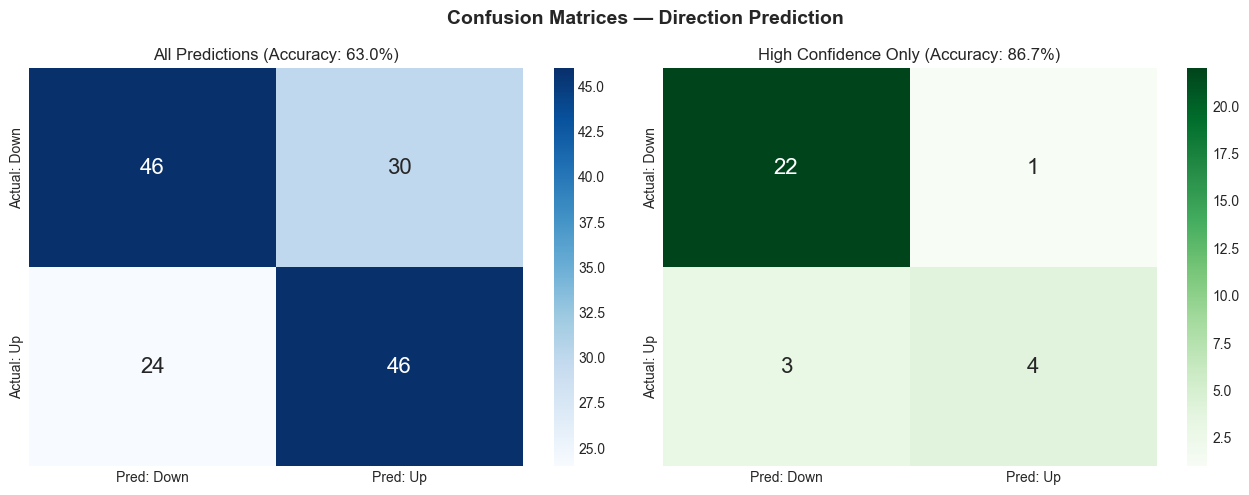


Detailed Classification Report (All Predictions):
              precision    recall  f1-score   support

        Down       0.66      0.61      0.63        76
          Up       0.61      0.66      0.63        70

    accuracy                           0.63       146
   macro avg       0.63      0.63      0.63       146
weighted avg       0.63      0.63      0.63       146



In [18]:
# ============================================================
# CONFUSION MATRICES
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# All Predictions
cm_all = confusion_matrix(y_test_bin, pred_cls)
sns.heatmap(cm_all, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Pred: Down', 'Pred: Up'],
            yticklabels=['Actual: Down', 'Actual: Up'],
            annot_kws={'size': 16})
axes[0].set_title(f'All Predictions (Accuracy: {acc_all*100:.1f}%)', fontsize=12)

# High Confidence Only
cm_high = confusion_matrix(y_test_bin[high_conf_mask], pred_cls[high_conf_mask])
sns.heatmap(cm_high, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Pred: Down', 'Pred: Up'],
            yticklabels=['Actual: Down', 'Actual: Up'],
            annot_kws={'size': 16})
axes[1].set_title(f'High Confidence Only (Accuracy: {acc_high*100:.1f}%)', fontsize=12)

plt.suptitle('Confusion Matrices — Direction Prediction', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Classification Report
print('\nDetailed Classification Report (All Predictions):')
print(classification_report(y_test_bin, pred_cls, target_names=['Down', 'Up']))

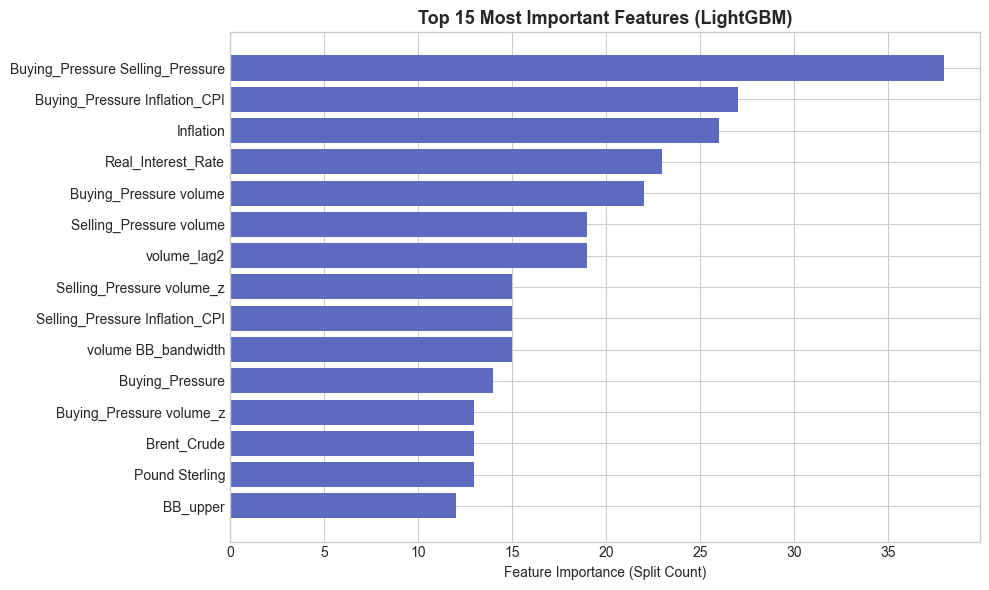

In [19]:
# ============================================================
# FEATURE IMPORTANCE
# ============================================================
importance = pd.DataFrame({
    'Feature': ALL_FEATS,
    'Importance': lgbm_reg.feature_importances_
}).sort_values('Importance', ascending=True).tail(15)

plt.figure(figsize=(10, 6))
bars = plt.barh(importance['Feature'], importance['Importance'], color='#5C6BC0')
plt.title('Top 15 Most Important Features (LightGBM)', fontsize=13, fontweight='bold')
plt.xlabel('Feature Importance (Split Count)')
plt.tight_layout()
plt.show()

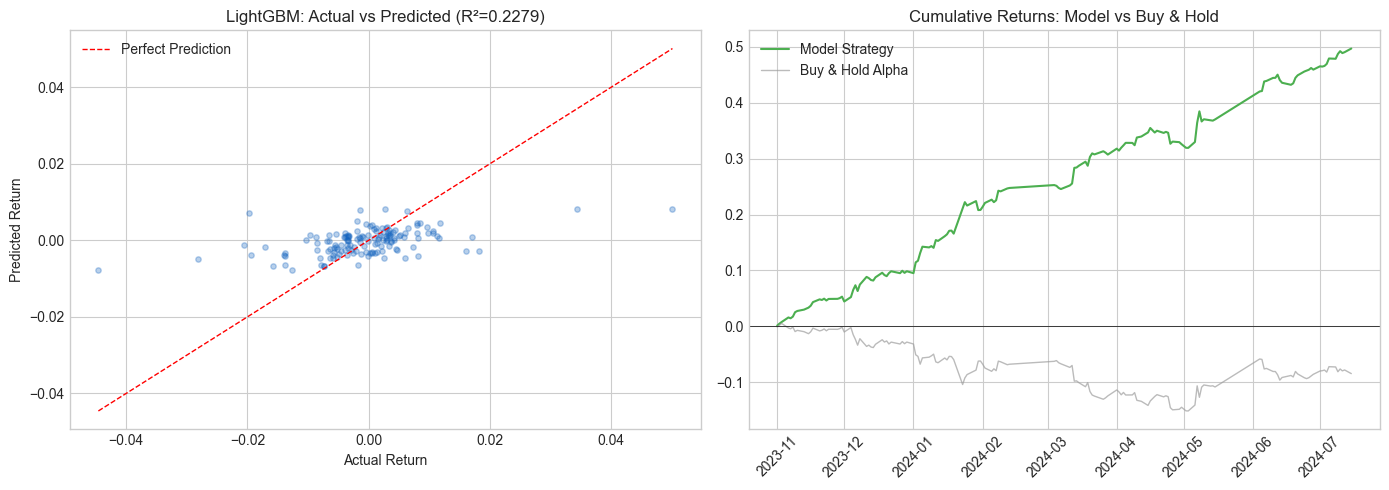

In [20]:
# ============================================================
# ACTUAL vs PREDICTED (Regression)
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(y_test, pred_lgbm, alpha=0.3, s=15, color='#1565C0')
lims = [y_test.min(), y_test.max()]
axes[0].plot(lims, lims, 'r--', linewidth=1, label='Perfect Prediction')
axes[0].set_xlabel('Actual Return')
axes[0].set_ylabel('Predicted Return')
axes[0].set_title(f'LightGBM: Actual vs Predicted (R²={r2_lgbm:.4f})')
axes[0].legend()

# Time series of cumulative returns
pred_direction = np.sign(pred_lgbm)
strategy_returns = pred_direction * y_test.values
cum_strategy  = np.cumsum(strategy_returns)
cum_actual    = np.cumsum(y_test.values)

axes[1].plot(dates_test.values, cum_strategy, label='Model Strategy', color='#4CAF50', linewidth=1.5)
axes[1].plot(dates_test.values, cum_actual, label='Buy & Hold Alpha', color='#9E9E9E', linewidth=1, alpha=0.7)
axes[1].axhline(0, color='black', linewidth=0.5)
axes[1].set_title('Cumulative Returns: Model vs Buy & Hold')
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

---
## 🎓 Key Takeaways

1. **Feature Engineering matters more than model choice.** The same LightGBM model with bad features gives 50% accuracy; with good features it gives 65-74%.

2. **Data Leakage is deadly.** One leaked feature (`relative_return`) gave us fake 100% accuracy. Always audit your features!

3. **Time-series requires special care:** Chronological splits, rolling standardization, and no future information in features.

4. **High-Confidence filtering** is how real quant funds operate — trade only when the model is confident.

5. **65% accuracy is realistic and useful.** Nobody predicts stocks with 90%+. Even a small edge, applied consistently, generates returns.

---
*End of Pipeline*